# Some Helpful Features


- Visualizing images/dataset
- Genearating visual cue for updates nd visualizing them in tensorboard

In [41]:
import tensorflow as tf
import numpy as np
import io
import matplotlib.pyplot as plt
import sklearn.metrics

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
(train_x, train_y), (validation_x, validation_y) = fashion_mnist

In [5]:
train_x.shape

(60000, 28, 28)

## Single Image Import

In [6]:
!rm -rf logs

In [7]:
logdir = 'logs'
file_writer = tf.summary.create_file_writer(logdir)

with file_writer.as_default():
    img = np.reshape(train_x[0], (-1, 28,28, 1))
    tf.summary.image("training data", img, step=0)

In [8]:
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


## Multiple image import

In [14]:
with file_writer.as_default():
    imgs = np.reshape(train_x[:50], (-1, 28, 28, 1))
    tf.summary.image('50 training data', imgs, max_outputs=50, step=0)

## Custom image data



In [25]:
def plot_to_image(figure):
    '''Converts the matplotlib plot to PNG dat'''
    # save the plot as png
    buf = io.BytesIO()
    figure.savefig(buf, format='png')
    # close the figure
    plt.close(figure)
    buf.seek(0)
    # convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    #add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

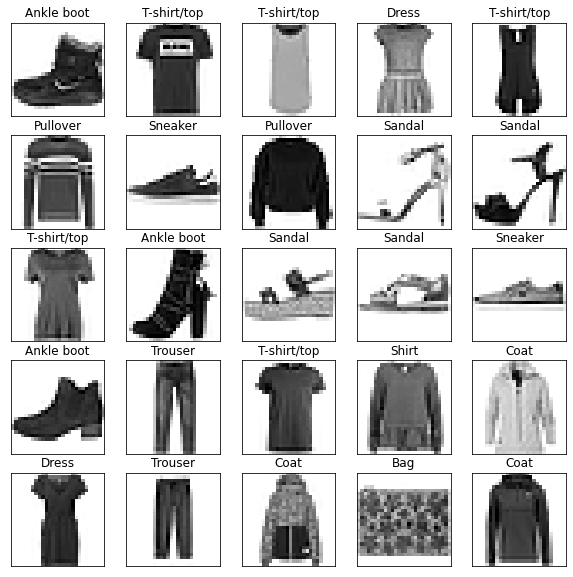

In [26]:
figure = plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1, title=class_names[train_y[i]])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_x[i], cmap=plt.cm.binary)

In [28]:
with file_writer.as_default():
    tf.summary.image('Custom Image 2', plot_to_image(figure), step=0)

## Visualizing training properly

In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [30]:
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])

### Using Confusion Matrix to visualize model

In [44]:
def plt_confusion_matrix(cm, class_names):
    '''
    Creates the matplotlib figure to visualize a confusion matrix of the model predictions
    
    Args:
        cm(array, shape=[n, n])
    '''
    # plot the confusion matrix
    figure = plt.figure(figsize=(10,10))
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    
    
    # use white text if square is dark else black
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    return figure

In [33]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')

In [46]:
def log_confusion_matrix(epoch, logs):
    '''Custom callback function'''
    # get the prediction data
    test_pred_raw = model.predict(validation_x)
    test_pred = np.argmax(test_pred_raw, axis=1)
    
    #calculate the confusion matrix
    cm = sklearn.metrics.confusion_matrix(validation_y, test_pred)
    figure = plt_confusion_matrix(cm, class_names)
    cm_image = plot_to_image(figure)
    
    with file_writer_cm.as_default():
        tf.summary.image('Confusion Matrix', cm_image, step=epoch)

cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [47]:
model.fit(
    train_x,
    train_y,
    epochs=10,
    callbacks=[tensorboard_callback, cm_callback],
    validation_data=(validation_x, validation_y)
)

Epoch 1/10
1875/1875 [==============================] - 8s 5ms/step - loss: 0.4754 - accuracy: 0.8389 - val_loss: 0.5947 - val_accuracy: 0.8016
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4654 - accuracy: 0.8436 - val_loss: 0.5973 - val_accuracy: 0.8246
Epoch 3/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.4662 - accuracy: 0.8431 - val_loss: 0.5275 - val_accuracy: 0.8369
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4645 - accuracy: 0.8441 - val_loss: 0.5169 - val_accuracy: 0.8378
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4442 - accuracy: 0.8507 - val_loss: 0.5159 - val_accuracy: 0.8396
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4548 - accuracy: 0.8485 - val_loss: 0.5434 - val_accuracy: 0.8332
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4413 - accuracy: 0.8511 - val_loss: 0.4895 - val_accuracy:

In [48]:
%load_ext tensorboard

In [49]:
%tensorboard --logdir logs